# **An Implementation of Node2Vec Model**

Here I implemented a Graph Embedding model - [Node2Vec model](https://arxiv.org/abs/1607.00653) and analyzed the impact of different parameters on the embedding.

# **Part 1: Load Graph**

## 1.1 Necessary packages

In [ ]:
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('ggdrive')

path = 'ggdrive/MyDrive/CTR/Node2vec/'
fnms = ['bridge.txt', 'flower.txt', 'karate_club.txt', 'random_geometric.txt']

testing = 'testing' # print result for code debugging

Drive already mounted at ggdrive; to attempt to forcibly remount, call drive.mount("ggdrive", force_remount=True).


In [ ]:
# karate_club.txt
if 1 == 2:
  g = nx.karate_club_graph()
  with open('karate_club.txt', 'w') as f:
    for i, j in g.edges():
      f.write(f'{i} {j}\n')

# random_geometric
if 1 == 2:
  g = nx.random_geometric_graph(50, 0.3)
  nx.draw(g, with_labels=True)
  with open('random_geometric.txt', 'w') as f:
    for i, j in g.edges():
      f.write(f'{i} {j}\n')

## 1.2 Load graph

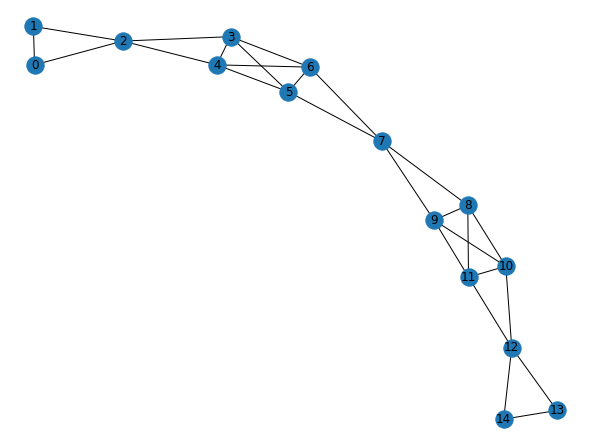

In [ ]:
def load_graph(filename):
  g = nx.Graph()
  with open(filename, 'r') as f:
    line = f.readline()
    while line:
      wds = line.split()
      src, dst = wds[0], wds[1]
      g.add_edge(src, dst)
      if g[src][dst].get('weight') == None:
        g[src][dst]['weight'] = 1
      else:
        g[src][dst]['weight'] += 1
      line = f.readline()
  return g

# testing
if testing == 'testing':
  g = load_graph(path + fnms[0])
  fig = plt.figure(figsize=(8,6))
  nx.draw(g, with_labels=True)

# **Part 2: Build Training Data Via Flexible Random Walk Sampling Strategy**

## 2.1 Alias sampling
![a](https://drive.google.com/uc?export=view&id=11ar1QvxwixSpqY5uow6myqd5BlnlDGJ2)

In [ ]:
def alias_sample(probs):
  l = len(probs)
  # prob_t: prob threshold
  # alter: alternative label
  prob_t, alter = np.zeros(l), np.zeros(l, dtype=np.int)
  small, large =[], []

  # initial
  for i, prob in enumerate(probs):
    prob_t[i] = l * prob ###
    if prob_t[i] < 1.0:
      small.append(i)
    else:
      large.append(i)
  
  # update 
  while small and large:
    sma, lar = small.pop(), large.pop()
    alter[sma] = lar
    prob_t[lar] -= 1.0 - prob_t[sma]
    if prob_t[lar] < 1.0:
      small.append(lar)
    else:
      large.append(lar)
  
  return alter, prob_t

# testing
if testing == 'testing':
  print(alias_sample([0.3, 0.1, 0.1, 0.5]))

(array([0, 3, 3, 0]), array([1. , 0.4, 0.4, 0.8]))


## 2.2 2-nd random walk

In [ ]:
def sec_random_walk(g, src, dst, p=1.0, q=1.0):
  # adjust transition probability
  probs = []
  for nei in sorted(g.neighbors(dst)):
    if nei == src:
      probs.append(g[dst][nei]['weight'] / p)
    elif g.has_edge(nei, src):
      probs.append(g[dst][nei]['weight'])
    else:
      probs.append(g[dst][nei]['weight'] / q)
  # normalize probs
  z_probs = sum(probs)
  for i in range(len(probs)):
    probs[i] /= z_probs
  return alias_sample(probs)

# testing
if testing == 'testing':
  print(sec_random_walk(g, '3', '6', q=0.5))

(array([3, 3, 3, 0]), array([0.8, 0.8, 0.8, 1. ]))


## 2.3 Preprocess transition probability

In [ ]:
def transition_probs(g, p=1.0, q=1.0):
  trans_1, trans_2 = {}, {}
  for src in g.nodes():
    if len(list(g.neighbors(src))) == 0:
      continue
    # 1-order random walk
    probs = [g[src][dst]['weight'] for dst in sorted(g.neighbors(src))]
    z_probs = sum(probs)
    for i in range(len(probs)):
      probs[i] /= z_probs
    trans_1[src] = alias_sample(probs)

    # 2-order random walk
    for dst in g.neighbors(src):
      trans_2[src, dst] = sec_random_walk(g, src, dst, p, q)

  return trans_1, trans_2

# testing
if testing == 'testing':
  trans_1, trans_2 = transition_probs(g)
  print('='*10, ' trans_1 ', '='*10)
  for k, v in trans_1.items():
    print(k, v)
  print('='*10, ' trans_2 ', '='*10)
  for k, v in trans_2.items():
    print(k, v)

==========  trans_1  ==========
0 (array([0, 0]), array([1., 1.]))
1 (array([0, 0]), array([1., 1.]))
2 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
3 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
4 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
5 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
6 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
7 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
8 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
9 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
10 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
11 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
12 (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
13 (array([0, 0]), array([1., 1.]))
14 (array([0, 0]), array([1., 1.]))
==========  trans_2  ==========
('0', '1') (array([0, 0]), array([1., 1.]))
('0', '2') (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
('1', '0') (array([0, 0]), array([1., 1.]))
('1', '2') (array([0, 0, 0, 0]), array([1., 1., 1., 1.]))
('2', '0') (array([0, 0]), array([1., 1.]))
('2'

## 2.4 Random walk sampling to build training data

In [ ]:
def random_walk_seq(g, start, trans_1, trans_2, seq_length=30):
  seq = [start]
  while len(seq) < seq_length:
    node = seq[-1]
    neis = sorted(g.neighbors(node))
    if len(neis) > 0:
      # sampling probs
      if len(seq) == 1:
        alter, prob_t = trans_1[node]
      else:
        alter, prob_t = trans_2[seq[-2], node]
      
      # alias sampling
      idx = int(np.floor(np.random.rand() * len(alter)))
      if np.random.rand() < prob_t[idx]:
        seq.append(neis[idx])
      else:
        seq.append(neis[alter[idx]])
    else:
      break
  return seq

# testing
if testing == 'testing':
  print(random_walk_seq(g, '1', trans_1, trans_2, 5))

['1', '0', '2', '3', '4']


In [ ]:
def get_train_seqs(g, num_walks=10, start_nodes=None, p=1.0, q=1.0, seq_length=30):
  trans_1, trans_2 = transition_probs(g, p, q)
  if not start_nodes:
    start_nodes = list(g.nodes())

  seqs = []
  for nwk in range(num_walks):
    idxs = np.array(range(len(start_nodes)))
    np.random.shuffle(idxs)
    for node in [start_nodes[j] for j in idxs]:
      seq = random_walk_seq(g, node, trans_1, trans_2, seq_length)
      if len(seq) > 1:
        seqs.append(seq)
  return seqs

# testing
if testing == 'testing':
  print(get_train_seqs(g))

[['10', '8', '9', '11', '12', '11', '12', '11', '10', '9', '11', '8', '9', '8', '9', '7', '6', '3', '6', '7', '9', '8', '9', '7', '6', '4', '6', '7', '9', '8'], ['0', '1', '2', '1', '2', '4', '3', '6', '5', '7', '8', '9', '8', '7', '5', '7', '6', '5', '3', '5', '7', '8', '9', '7', '8', '11', '10', '12', '14', '13'], ['9', '11', '12', '13', '14', '12', '13', '14', '13', '12', '11', '12', '14', '12', '14', '12', '13', '12', '14', '12', '11', '10', '12', '13', '12', '10', '12', '13', '14', '13'], ['4', '3', '5', '7', '6', '5', '4', '5', '7', '8', '10', '11', '12', '14', '13', '12', '10', '8', '11', '10', '11', '9', '11', '10', '9', '7', '6', '4', '6', '7'], ['5', '3', '4', '3', '6', '4', '3', '5', '3', '2', '1', '2', '1', '0', '1', '2', '3', '4', '6', '4', '6', '4', '6', '7', '9', '11', '9', '7', '6', '4'], ['8', '9', '10', '12', '13', '14', '13', '14', '12', '13', '14', '13', '14', '13', '14', '13', '12', '14', '12', '10', '9', '11', '8', '10', '11', '9', '10', '9', '10', '11'], ['13', '

# **Part 3: Train Node2vec**

In [ ]:
def node2vec_embedding(g, seqs, emb_size=8, sg=1, negative=10, 
                       window=5, min_count=0, iter=20):
  model = Word2Vec(seqs, size=emb_size,
                   sg=sg, negative=negative, 
                   window=window, iter=iter,
                   min_count=min_count)
  emb = []
  for node in g.nodes():
    emb.append(model.wv.get_vector(node))
  emb = np.array(emb)
  return emb

# testing
if testing == 'testing':
  seqs = get_train_seqs(g)
  emb = node2vec_embedding(g, seqs, emb_size=2)
  print(emb)

[[ 0.77887124 -2.1800377 ]
 [ 1.0221035  -2.4498522 ]
 [ 0.51003957 -1.8823025 ]
 [ 0.3475367  -1.6792514 ]
 [ 0.22314961 -1.6074914 ]
 [-0.01487867 -1.4297855 ]
 [ 0.09978814 -1.499243  ]
 [-0.35297456 -1.2210706 ]
 [-0.98793703 -1.060387  ]
 [-1.0706396  -1.0481238 ]
 [-1.3263029  -1.0809317 ]
 [-1.242025   -1.048147  ]
 [-1.8508353  -1.0411652 ]
 [-2.113724   -1.0652025 ]
 [-2.116066   -1.0758448 ]]


# **Part 4: Experiments**

## 4.1 Training function

In [ ]:
from sklearn.cluster import KMeans

def train(fnm, ps=[0.5, 1.0, 2.0], qs=[0.1, 1.0, 10.0], seq_length=30, 
          num_walks=5, start_nodes=None, ncluster=5,
          emb_size=16, negative=10, window=5, epochs=200):
  g = load_graph(path + fnm)
  pos = nx.spring_layout(g)
  m, n = len(ps), len(qs)
  fig, axs = plt.subplots(m, n, figsize=(m*5, n*5))
  for i in range(m):
    for j in range(n):
      seqs = get_train_seqs(g, num_walks=num_walks,
                            start_nodes=start_nodes,
                            p=ps[i], q=qs[j], 
                            seq_length=seq_length)
      emb = node2vec_embedding(g, seqs=seqs, emb_size=emb_size,
                               sg=1, negative=negative, 
                               window=window, iter=epochs)
      kmeans = KMeans(n_clusters=ncluster, random_state=42).fit(emb)
      nx.draw(g, pos, node_color=list(kmeans.labels_), 
              with_labels=True, cmap=plt.cm.Paired,
              ax=axs[i][j])
      axs[i][j].set_title(f'p={ps[i]}, q={qs[j]}', fontsize=10)
  fig.suptitle(f'Graph Embedding Clusters for "{fnm}"')

## 4.2 Check the homophily and structural equivalence

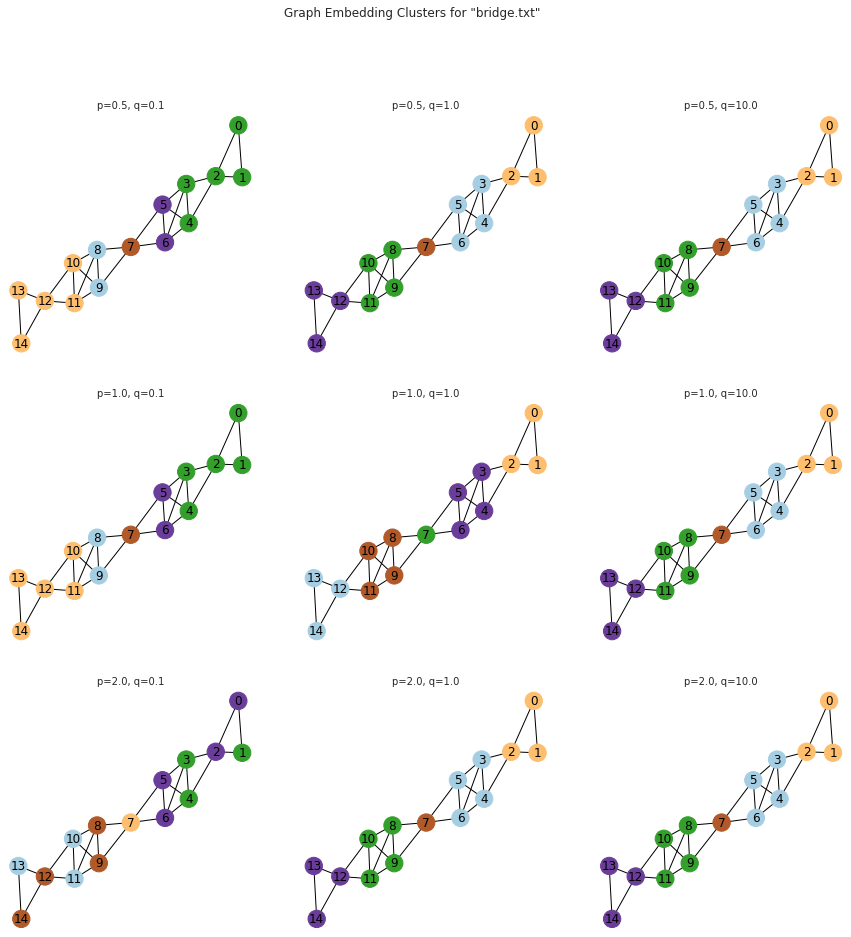

In [ ]:
train(fnms[0], seq_length=10, window=2)

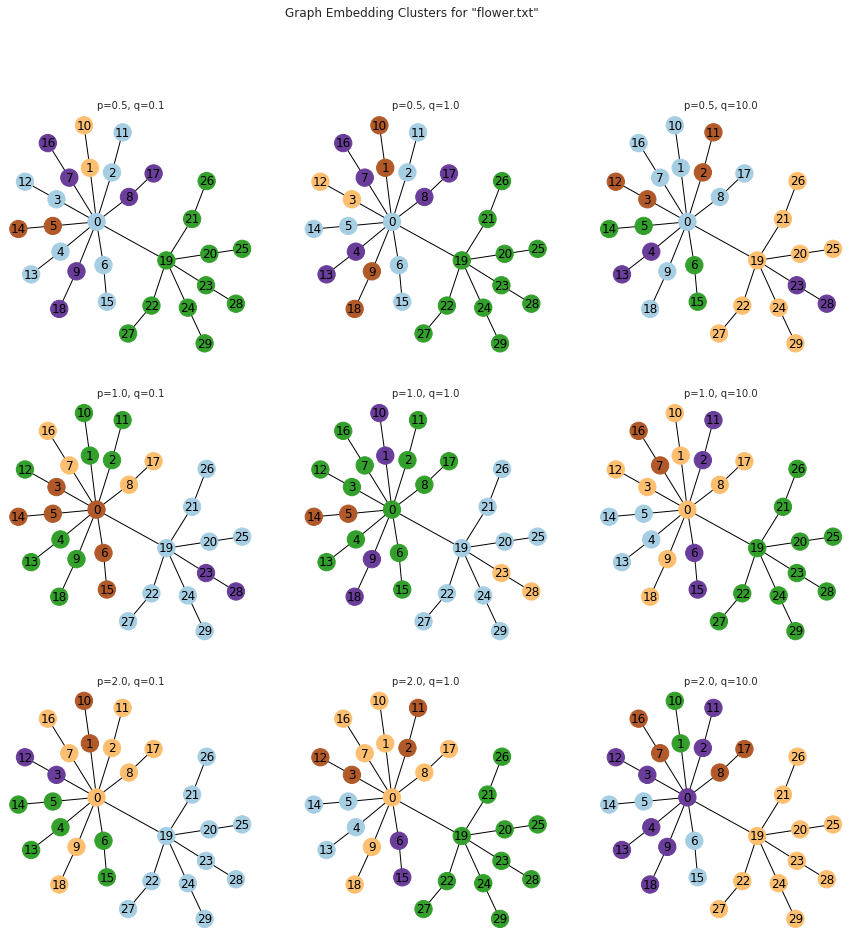

In [ ]:
train(fnms[1], ncluster=5, seq_length=7, window=1)

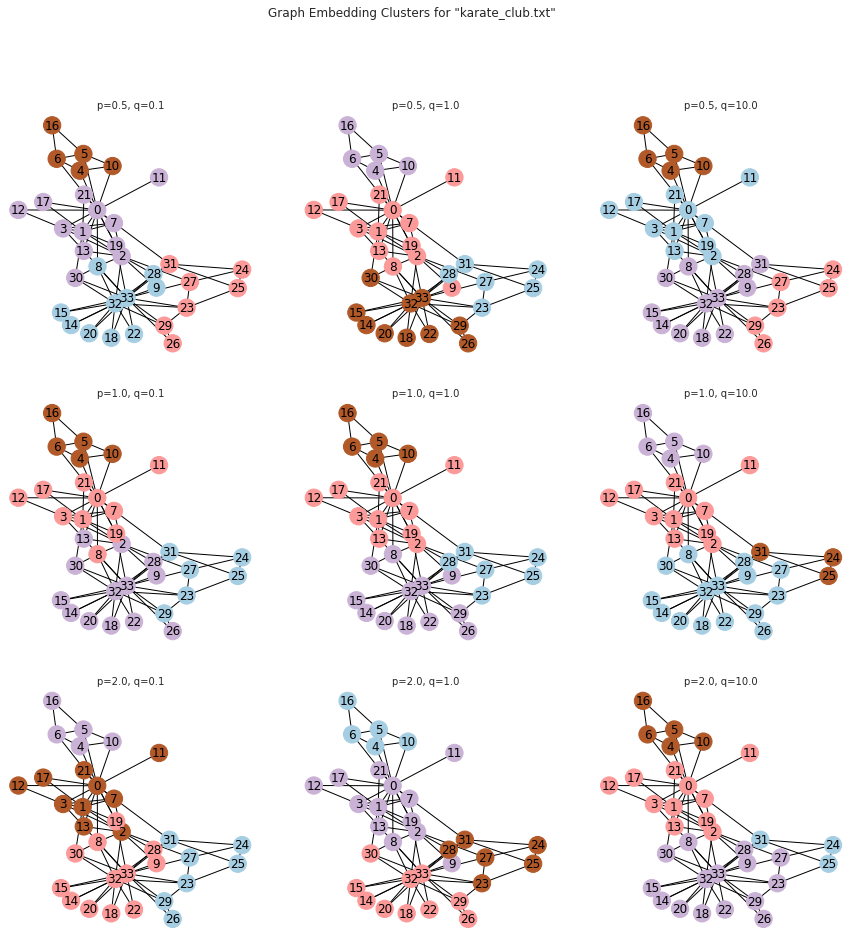

In [ ]:
train(fnms[2], ncluster=4, seq_length=30, window=2)

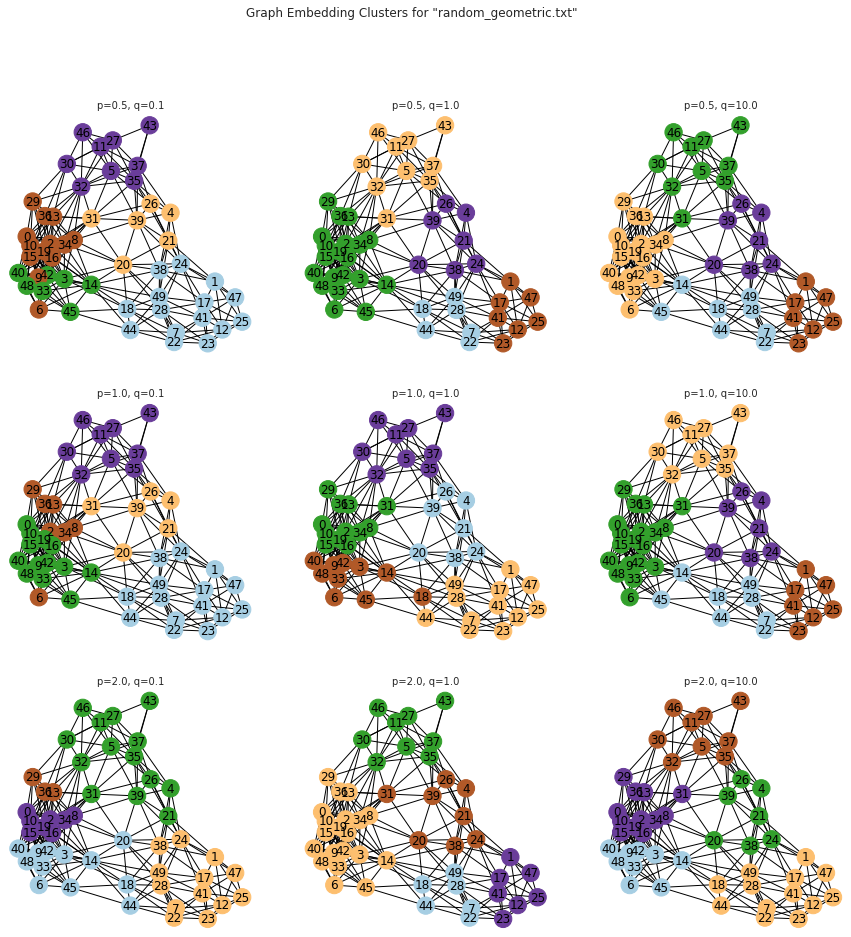

In [ ]:
train(fnms[3], ncluster=5, seq_length=25, window=1, num_walks=5)

# **Part 5: Observations**

[探索node2vec同质性和结构性之谜](https://zhuanlan.zhihu.com/p/68453999)[[github](https://github.com/familyld/A_Simple_node2vec_Example)]

1. 到底什么是网络的同质性？什么是网络的结构性？
2. DFS 是否擅长刻画同质性，BFS 是否擅长刻画结构性？为什么？

**DFS擅长学习网络的同质性**
  - 作者说的同质性是能模型能找出每个簇的边界，使得簇内结点彼此联系的紧密程度要超过跟簇外结点的联系，这就要求模型有更大的感受野，DFS 这种能跳出局部的方式就很适合这个要求

**BFS擅长学习网络的结构性**
  - 作者说的结构性并不是宏观上有相似的连接方式，而是指能够**充分学习微观上的局部结构**